# Import

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from enum import Enum
from tqdm import tqdm
import random

# Constants

In [ ]:
# Define constants
CHESSBOARD_SIZE = (7, 6)
AXIS = np.float32([[3, 0, 0], [0, 3, 0], [0, 0, -3]]).reshape(-1, 3)
AXIS_CUBE = np.float32([[0, 0, 0], [0, 3, 0], [3, 3, 0], [3, 0, 0],
                         [0, 0, -3], [0, 3, -3], [3, 3, -3], [3, 0, -3]])

# Define criteria for corner sub-pix
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
OBJP = np.zeros((CHESSBOARD_SIZE[0] * CHESSBOARD_SIZE[1], 3), np.float32)
OBJP[:, :2] = np.mgrid[0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)

# Define directories
OUPUT_DIR = 'images'
CALIBRATE_DIR = 'calibration'

In [3]:
def load_images(output_dir):
    """Load images from a specified directory."""
    return [f for f in os.listdir(output_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Calibration

In [ ]:
def find_chessboard_corners(video_path):
    """Function to find chessboard corners in the video."""
    objpoints = []  # 3D points in real-world space
    imgpoints = []  # 2D points in image plane
    images = []     # To store detected chessboard images

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return objpoints, imgpoints, images

    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for frame_idx in tqdm(range(total_frames), desc='Processing frames'):
        ret, frame = cap.read()
        if not ret:
            print("End of video or failed to capture image.")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        found, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, None)

        if found:
            # Refine corners for sub-pixel accuracy
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), CRITERIA)

            # Add object points and image points to lists
            objpoints.append(OBJP)
            imgpoints.append(corners2)
            images.append(gray)

    print(f"Finished capturing patterns. Total patterns detected: {len(imgpoints)}")
    cap.release()
    return objpoints, imgpoints, images


In [ ]:
def save_images(images, number,output_dir):
    """Function to save random images from the detected images."""
    num_images_to_save = min(number, len(images))
    selected_indices = random.sample(range(len(images)), num_images_to_save)

    saved_paths = []
    for idx in selected_indices:
        image_path = os.path.join(output_dir, f'pattern_detected_{idx + 1}.png')
        cv2.imwrite(image_path, images[idx])  # Save the image
        saved_paths.append(image_path)  # Store the path
        print(f'Saved: {image_path}')
    
    return saved_paths

In [ ]:
def calibrate_camera(objpoints, imgpoints, gray_shape, sensor_width_m=0.024):
    """Function to calibrate the camera and calculate focal length in pixels and meters."""
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_shape[::-1], None, None)

    f_x = mtx[0, 0]
    f_y = mtx[1, 1]

    focal_length_px = (f_x + f_y) / 2

    print("Focal length in pixels (fx):", f_x)
    print("Focal length in pixels (fy):", f_y)
    print("Focal length in pixels:", focal_length_px)

    image_width_px = gray_shape[1]

    # Calculate focal length in meters
    focal_length_m = (f_x * sensor_width_m) / image_width_px

    print("Focal length in meters:", focal_length_m)

    return mtx, dist, rvecs, tvecs


def undistort_image(image_path, mtx, dist):
    """Function to undistort an image."""
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # Crop the image using ROI
    x, y, w, h = roi
    dst_roi = dst[y:y+h, x:x+w]
    return dst,dst_roi

def save_undistorted_image(dst, output_filename):
    """Function to save the undistorted image."""
    cv2.imwrite(output_filename, dst)
    print(f'Saved undistorted image: {output_filename}')

def calculate_reprojection_error(objpoints, imgpoints, mtx, dist, rvecs, tvecs):
    """Function to calculate the re-projection error."""
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        mean_error += error

    print("Total re-projection error:", mean_error / len(objpoints))

## Affichage

In [7]:
def plot_images(saved_images_path):
    """Function to plot the saved images with detected corners."""
    # Get all image files from the specified directory
    image_files = load_images(saved_images_path)
    
    for idx, filename in enumerate(image_files):
        image_path = os.path.join(saved_images_path, filename)
        
        # Read the saved image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image at {image_path}")
            continue
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        found, corners = cv2.findChessboardCorners(gray, (7, 6), None)

        if found:
            # Refine corners for sub-pixel accuracy
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), CRITERIA)
            
            # Draw the corners on the image
            img_with_corners = cv2.drawChessboardCorners(img.copy(), (7, 6), corners2, found)

            # Display the image with detected corners inline
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
            plt.title(f'Detected Chessboard Corners for Image {idx + 1}')
            plt.axis('off')
            plt.show()
        else:
            print(f"No chessboard corners found in image {image_path}.")


## Main

In [8]:
# Main Execution
os.makedirs(OUPUT_DIR, exist_ok=True)

video_path = 'VID_20241103_111959064.mp4'
objpoints, imgpoints, images = find_chessboard_corners(video_path)

Processing frames: 100%|██████████| 580/580 [00:46<00:00, 12.58it/s]

Finished capturing patterns. Total patterns detected: 405


In [ ]:
# Calibration
num_images = 10
objpoints_tmp = objpoints[:num_images]
imgpoints_tmp = imgpoints[:num_images]
gray_shape = images[0].shape
mtx, dist, rvecs, tvecs = calibrate_camera(objpoints_tmp, imgpoints_tmp, gray_shape)
# Save the calibration data to B.npz
np.savez('B.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

Focal length in pixels (fx): 824.2217194024937
Focal length in pixels (fy): 823.5983721238057
Focal length in pixels: 823.9100457631497
Focal length in meters: 0.0231631396553394


In [12]:
# Undistort an example image
example_image_path = os.path.join(OUPUT_DIR, 'pattern_detected_381.png')  # Update to a valid image path
undistorted_image,undistorted_image_roi = undistort_image(example_image_path, mtx, dist)

# Save undistorted image
save_undistorted_image(undistorted_image, os.path.join(CALIBRATE_DIR,'calibresult.png'))
save_undistorted_image(undistorted_image_roi, os.path.join(CALIBRATE_DIR,'calibresultROI.png'))

Saved undistorted image: calibration\calibresult.png
Saved undistorted image: calibration\calibresultROI.png


In [13]:
# Calculate re-projection error
calculate_reprojection_error(objpoints_tmp, imgpoints_tmp, mtx, dist, rvecs, tvecs)

Total re-projection error: 0.018735631117612676


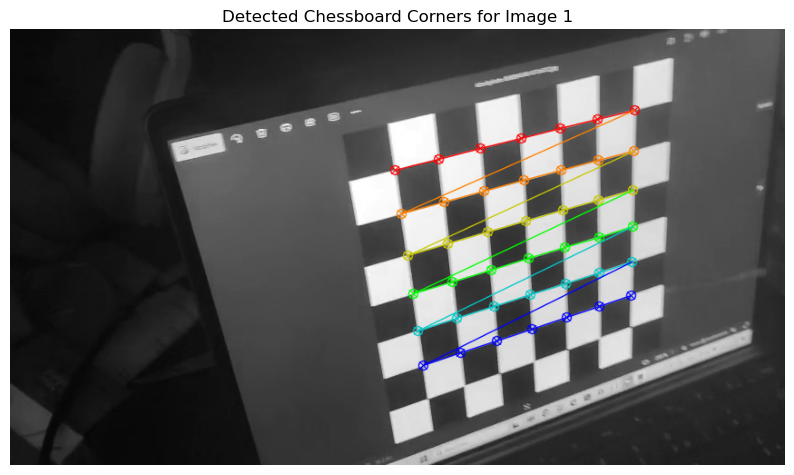

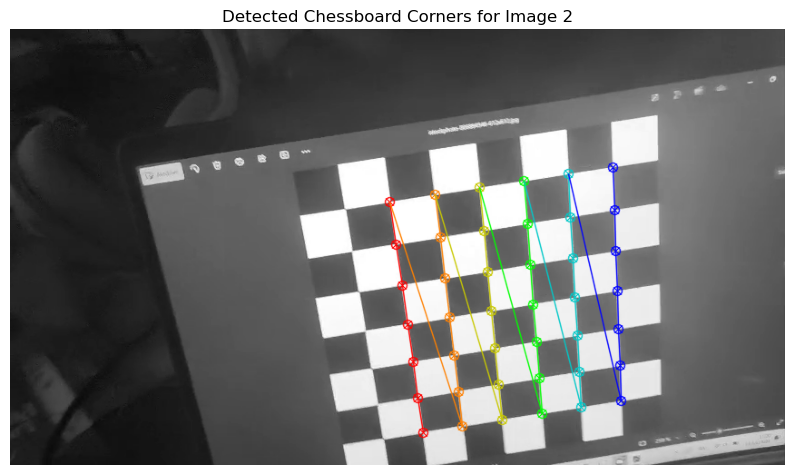

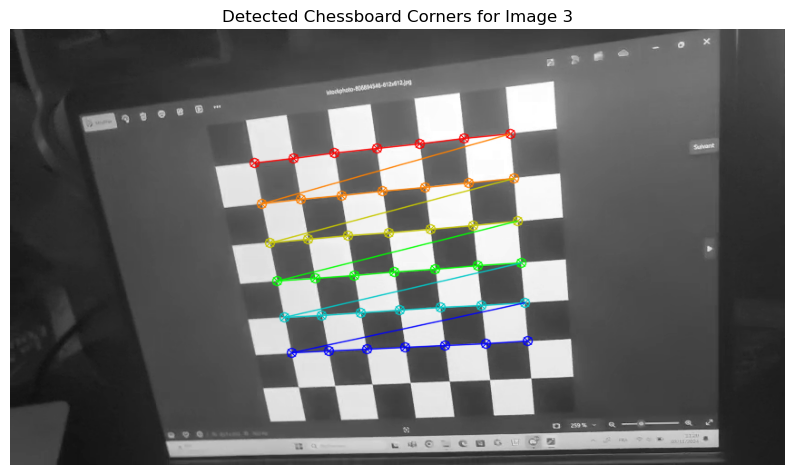

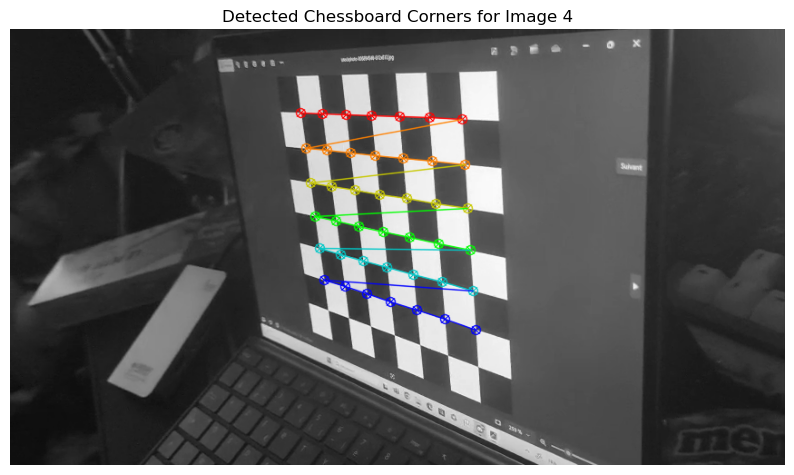

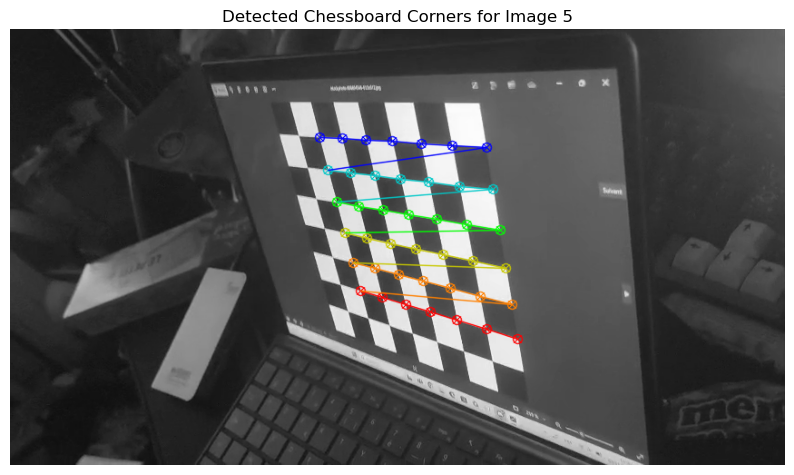

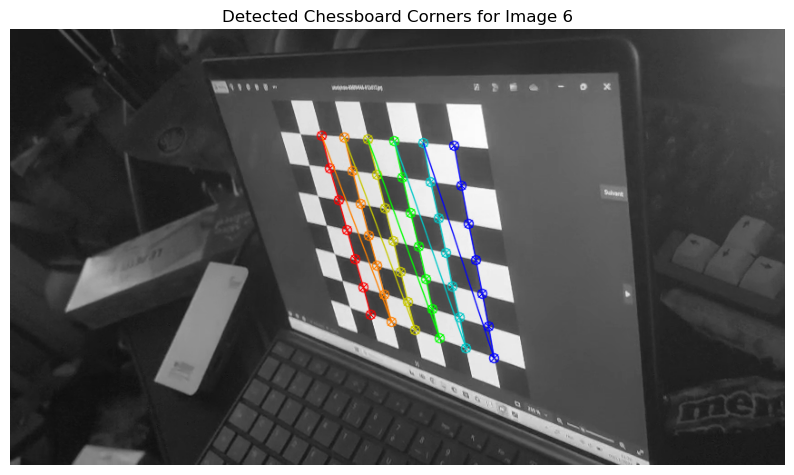

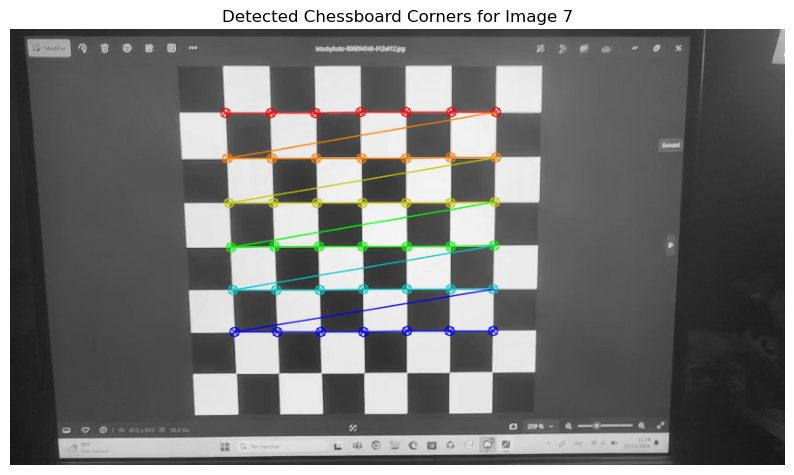

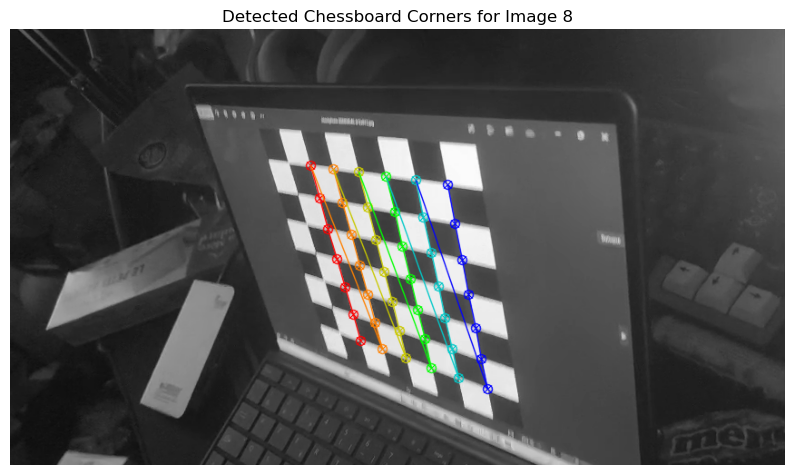

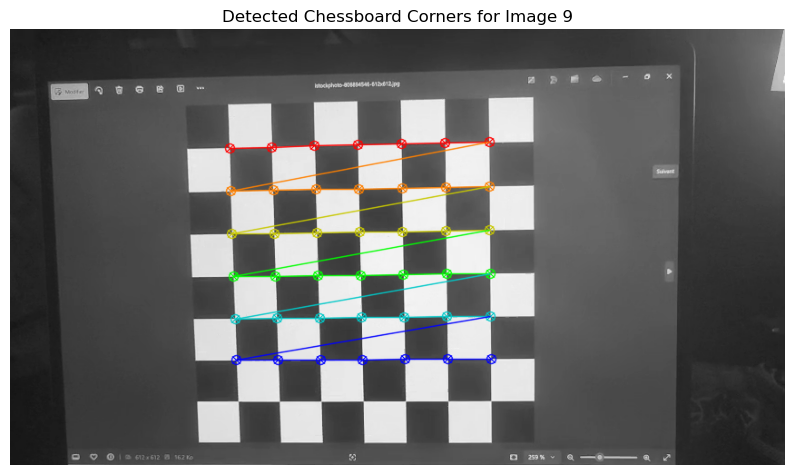

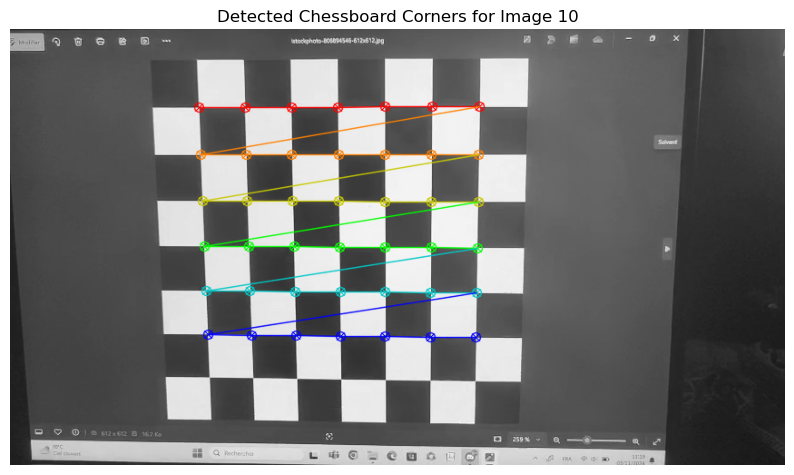

In [84]:
#saved_images = save_images(images, 10,output_dir=output_dir)  # Save 10 random images
plot_images(saved_images_path=OUPUT_DIR)  # Plot the saved images with corners

# Pose Estimation

In [85]:
# Load previously saved camera matrix and distortion coefficients
# with np.load('B.npz') as X:
#     mtx, dist, _, _ = [X[i] for i in ('mtx', 'dist', 'rvecs', 'tvecs')]

In [ ]:
# Enum for draw types
class DrawType(Enum):
    CUBE = 1
    AXIS = 2
    OBJ = 3

def draw_axis(img, corners, imgpts):
    if corners is not None and imgpts is not None and len(corners) > 0 and len(imgpts) > 0:
        corner = tuple(map(int, corners[0].ravel()))
        imgpts = imgpts.reshape(-1, 2)
        if imgpts.shape[0] >= 3:
            img = cv2.line(img, corner, tuple(map(int, imgpts[0])), (255, 0, 0), 5)
            img = cv2.line(img, corner, tuple(map(int, imgpts[1])), (0, 255, 0), 5)
            img = cv2.line(img, corner, tuple(map(int, imgpts[2])), (0, 0, 255), 5)
    return img

def draw_cube(img, imgpts):
    """Draw a 3D cube on the image based on projected points."""
    imgpts = np.int32(imgpts).reshape(-1, 2)
    
    # Draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -3)

    # Draw pillars in blue
    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255, 0, 0), 3)

    # Draw top layer in red
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)

    return img

def load_obj_model(file_path):
    """Load an OBJ model and return vertices and faces."""
    vertices = []
    faces = []

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):  # Vertex line
                vertex = list(map(float, line.strip().split()[1:]))
                vertices.append(vertex)
            elif line.startswith('f '):  # Face line
                # Handle faces with different formats (triangles and quads)
                face = [int(part.split('/')[0]) - 1 for part in line.strip().split()[1:]]
                if len(face) >= 3:  # Ensure that there are at least 3 vertices in a face
                    faces.append(face)

    return np.array(vertices, dtype=np.float32), np.array(faces, dtype=object)


def draw_obj_model(img, vertices, faces, rvecs, tvecs, mtx, dist):
    """Project OBJ model vertices and draw them on the image."""
    # Project the 3D vertices to 2D points
    imgpts, _ = cv2.projectPoints(vertices, rvecs, tvecs, mtx, dist)
    imgpts = imgpts.reshape(-1, 2)

    # Draw the model faces
    for face in faces:
        pts = imgpts[face].astype(np.int32).reshape(-1, 1, 2)
        cv2.polylines(img, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

    return img

def process_image(image_path, mtx, dist, draw_type, obj_path=None):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, None)

    if ret:
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), CRITERIA)
        _, rvecs, tvecs, _ = cv2.solvePnPRansac(OBJP, corners2, mtx, dist)

        if draw_type == DrawType.CUBE:
            imgpts, _ = cv2.projectPoints(AXIS_CUBE, rvecs, tvecs, mtx, dist)
            img = draw_cube(img, imgpts)
        elif draw_type == DrawType.AXIS:
            imgpts, _ = cv2.projectPoints(AXIS, rvecs, tvecs, mtx, dist)
            img = draw_axis(img, corners2, imgpts)
        elif draw_type == DrawType.OBJ and obj_path:
            vertices, faces = load_obj_model(obj_path)
            img = draw_obj_model(img, vertices, faces, rvecs, tvecs, mtx, dist)

    return img


def plot_images(processed_images, image_files):
    """Plot processed images in a grid."""
    num_images = len(processed_images)
    cols = 3
    rows = (num_images + cols - 1) // cols  # Calculate number of rows needed

    plt.figure(figsize=(15, 5 * rows))  # Adjust figure size based on number of rows
    for i, img in enumerate(processed_images):
        plt.subplot(rows, cols, i + 1)  # Create a subplot for each image
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'3D Object on Chessboard - {os.path.basename(image_files[i])}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Main processing routine
def main(output_dir, mtx, dist, draw_type, obj_path=None):
    """Main function to load images, process them, and plot results."""
    image_files = load_images(output_dir)
    processed_images = []

    for fname in image_files:
        image_path = os.path.join(output_dir, fname)
        processed_img = process_image(image_path, mtx, dist, draw_type,obj_path)
        if processed_img is not None:
            processed_images.append(processed_img)

    plot_images(processed_images, image_files)

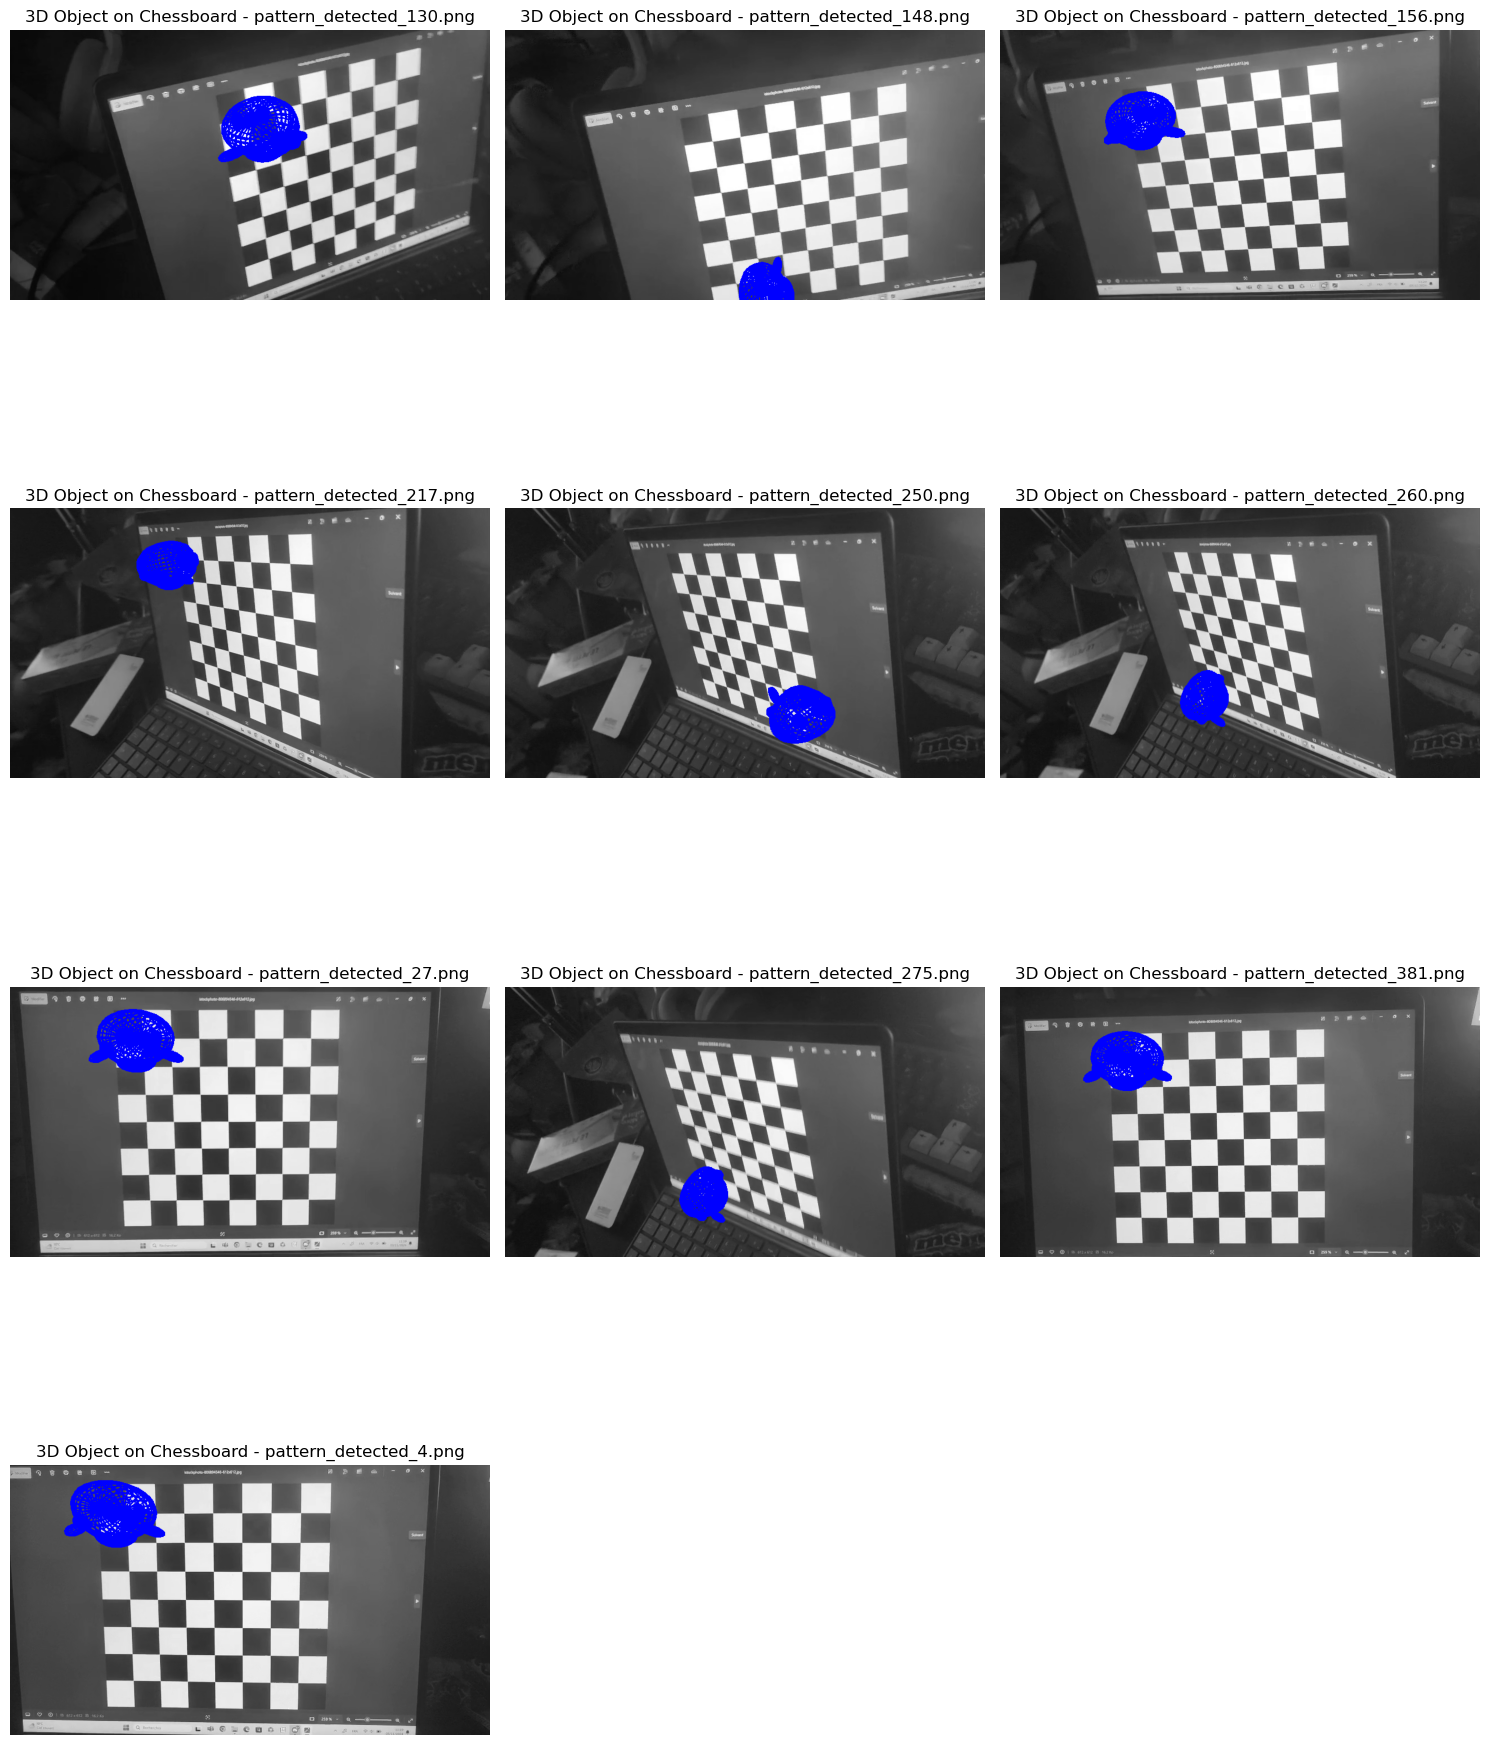

In [ ]:
main(OUPUT_DIR, mtx, dist, DrawType.OBJ,'obj.obj')

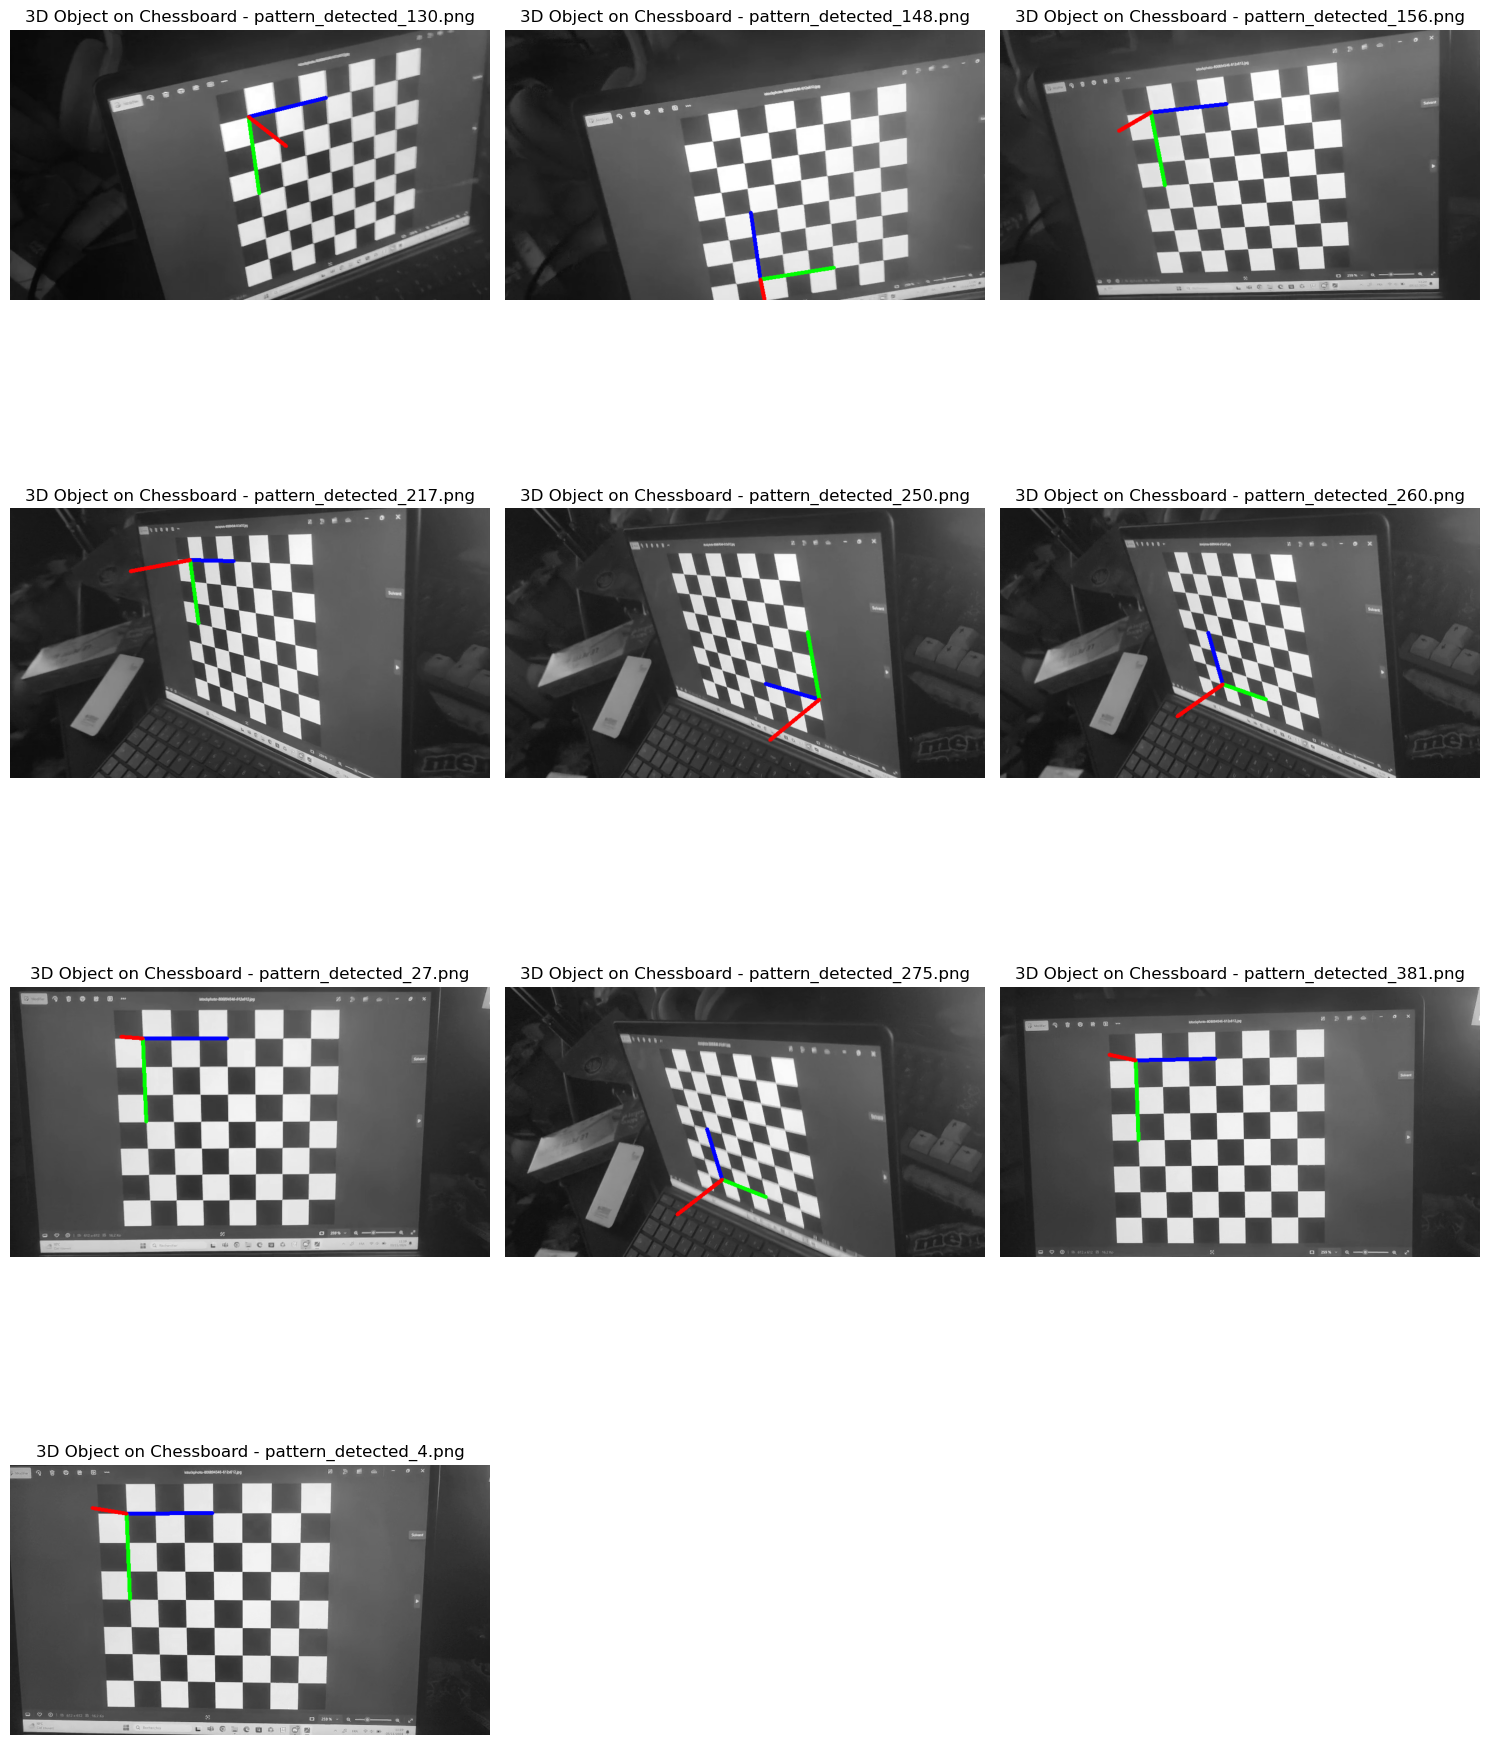

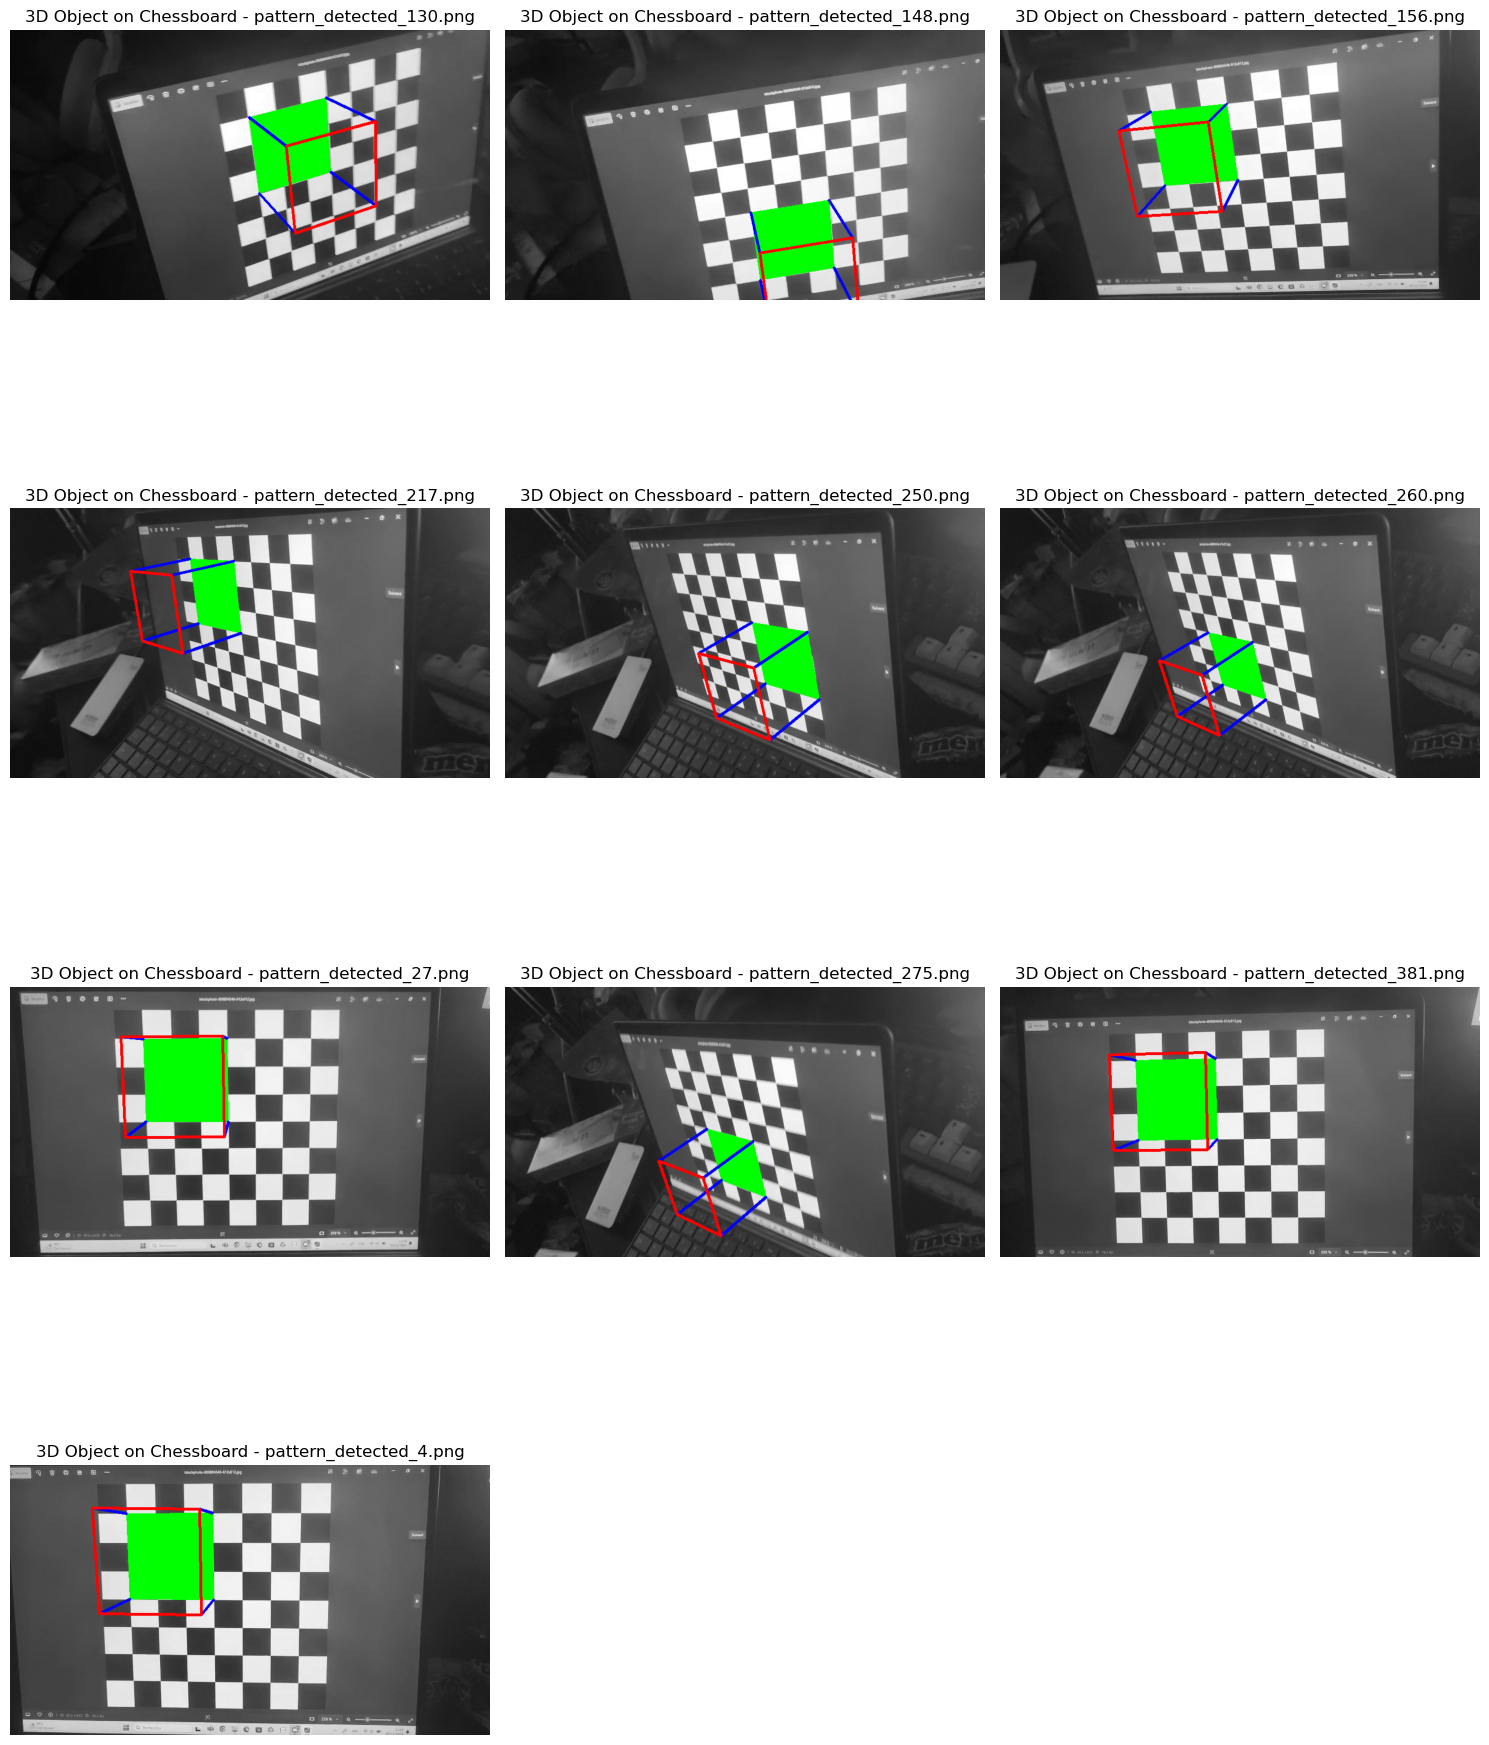

In [87]:
# Example usage
main(OUPUT_DIR, mtx, dist, DrawType.AXIS)
main(OUPUT_DIR, mtx, dist, DrawType.CUBE)